<a href="https://colab.research.google.com/github/shilz1007/shilz1007/blob/main/Scratch_Pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_graphics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import trimesh
import tensorflow as tf
import tensorflow_graphics as tfg
from tensorflow_graphics.datasets.modelnet40 import ModelNet40


In [ ]:
import os
import h5py
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # pylint:disable=unused-import

In [ ]:
_LABELS = [
    'airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car',
    'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot',
    'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor',
    'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
    'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase',
    'wardrobe', 'xbox'
]

In [ ]:
tfg.datasets.modelnet40.ModelNet40(
    _URL, None,
)

TypeError: ignored

In [ ]:
# Constants
_URL = '/content/drive/MyDrive/modelnet40_ply_hdf5_2048.zip'

In [ ]:
_CITATION = """
@inproceedings{qi2017pointnet,
  title={Pointnet: Deep learning on point sets for 3d classification and segmentation},
  author={Qi, Charles R and Su, Hao and Mo, Kaichun and Guibas, Leonidas J},
  booktitle={Proceedings of the IEEE conference on computer vision and pattern recognition},
  pages={652--660},
  year={2017},
}

SyntaxError: ignored

In [ ]:
"""

_DESCRIPTION = """
The dataset contains point clouds sampling CAD models from 40 different categories.
The files have been retrieved from https://modelnet.cs.princeton.edu
To generate each example, the authors first uniformly sampled a modelnet40 mesh
with 10000 uniform samples, and then employed furthest point sampling to downsample
to 2048 points. The procedure is explained [here](https://github.com/charlesq34/pointnet2/blob/master/tf_ops/sampling/tf_sampling.py)
"""

In [ ]:
class ModelNet40(tfds.core.GeneratorBasedBuilder):
  """ModelNet40."""

  VERSION = tfds.core.Version('1.0.0')

  @staticmethod
  def load(*args, **kwargs):
    return tfds.load('model_net40', *args, **kwargs)  # pytype: disable=wrong-arg-count

  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        ##description=_DESCRIPTION,
        features=tfds.features.FeaturesDict({
            'points': tfds.features.Tensor(shape=(2048, 3), dtype=tf.float32),
            'label': tfds.features.ClassLabel(names=_LABELS)
        }),
        supervised_keys=('points', 'label'),
        #homepage='https://modelnet.cs.princeton.edu',
        ##citation=_CITATION,
    )

  def _split_generators(self, download_manager):
    """Returns SplitGenerators."""

    extracted_path = download_manager.download_and_extract(_URL)

    # Note: VALIDATION split was not provided by the authors
    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs=dict(
                filename_list_path=os.path.join(
                    extracted_path,
                    'modelnet40_ply_hdf5_2048/train_files.txt'),)),
        tfds.core.SplitGenerator(
            name=tfds.Split.TEST,
            gen_kwargs=dict(
                filename_list_path=os.path.join(
                    extracted_path,
                    'modelnet40_ply_hdf5_2048/test_files.txt'),)),
    ]

  def _generate_examples(self, filename_list_path):
    """Yields examples."""

    ancestor_path = os.path.dirname(os.path.dirname(filename_list_path))
    with tf.io.gfile.GFile(filename_list_path, 'r') as fid:
      filename_list = fid.readlines()
    filename_list = [line.rstrip()[5:] for line in filename_list]

    example_key = -1  # as yield exists, need to pre-increment
    for filename in filename_list:
      h5path = os.path.join(ancestor_path, filename)

      with h5py.File(h5path, 'r') as h5file:
        points = h5file['data'][:]  # shape=(2048, 2048, 3)
        label = h5file['label'][:]  # shape=(2048, )

        models_per_file = points.shape[0]
        for imodel in range(models_per_file):
          example_key += 1
          yield example_key, {
              'points': points[imodel, :, :],
              'label': int(label[imodel])
          }

In [ ]:
ds_train, info = ModelNet40.load(
      split="train", data_dir="/content/drive/MyDrive/modelnet40", with_info=True)

In [ ]:
ds_test, info = ModelNet40.load(
      split="test", data_dir="/content/drive/MyDrive/modelnet40", with_info=True)

In [ ]:
for example in ds_train.take(1):
    points = example["points"]
    label = example["label"]
print("points.shape=", points.shape)
print("label.shape", label.shape)    

points.shape= (2048, 3)
label.shape ()


In [ ]:
print("Example of string='{}' to ID#={}".format(
      "airplane", info.features["label"].str2int("airplane")))
print("Example of ID#={} to string='{}'".format(
      12, info.features["label"].int2str(12)))

Example of string='airplane' to ID#=0
Example of ID#=12 to string='desk'


In [ ]:
for i in range(40):
  print(info.features["label"].int2str(i))

airplane
bathtub
bed
bench
bookshelf
bottle
bowl
car
chair
cone
cup
curtain
desk
door
dresser
flower_pot
glass_box
guitar
keyboard
lamp
laptop
mantel
monitor
night_stand
person
piano
plant
radio
range_hood
sink
sofa
stairs
stool
table
tent
toilet
tv_stand
vase
wardrobe
xbox


In [ ]:
ds_train, info = tfg.datasets.modelnet40.ModelNet40.load(split="train", with_info=True)
num_examples = info.splits["train"].num_examples
ds_train = ds_train.shuffle(num_examples, reshuffle_each_iteration=True)
#ds_train = ds_train.repeat(steps_per_epoch=20)
ds_train = ds_train.batch(batch_size=32)
ds_test = ds_test.batch(batch_size=32)

In [ ]:
ds_train

<BatchDataset element_spec={'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'points': TensorSpec(shape=(None, 2048, 3), dtype=tf.float32, name=None)}>

In [ ]:
ds_test

<BatchDataset element_spec={'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'points': TensorSpec(shape=(None, None, 2048, 3), dtype=tf.float32, name=None)}>

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(['points','label'])

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(['points','label'])

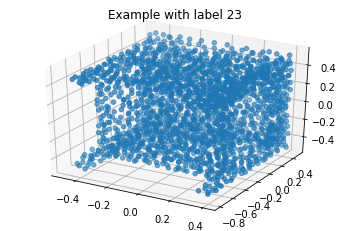

In [ ]:
fig = plt.figure()
ax3 = fig.add_subplot(111, projection="3d")
ax3.set_title("Example with label {}".format(label))
scatter3 = lambda p, c="r", *args: ax3.scatter(p[:, 0], p[:, 1], p[:, 2], c)
scatter3(points)

In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,Model,activations
from tensorflow.keras.layers import Activation,Dense,Flatten,Conv1D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import Regularizer
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
def conv_layer(x,filters):
  x = layers.Conv1D(filters,kernel_size=1,padding='valid')(x)
  x = layers.BatchNormalization(momentum=0.0)(x)
  return layers.Activation('relu')(x)

def dense_layers(x,filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_layer(inputs, 32)
    x = conv_layer(x, 64)
    x = conv_layer(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_layers(x, 256)
    x = dense_layers(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
input_shape =points.shape

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

x = tnet(inputs, 3)
x = conv_layer(x, 32)
x = conv_layer(x, 32)
x = tnet(x, 32)
x = conv_layer(x, 32)
x = conv_layer(x, 64)
x = conv_layer(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_layers(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_layers(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(label, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
model.fit(train_dataset,epochs=50,batch_size=32,steps_per_epoch=10,validation_data=test_dataset)

Epoch 1/50


ValueError: ignored

Another Method

In [ ]:
Data_ModelNet_40 = tf.keras.utils.get_file(
    "modelnet40_ply_hdf5_2048.zip",
    "file:///content/drive/MyDrive/modelnet40_ply_hdf5_2048.zip",
    extract=True,
)                        
Data_ModelNet_40 = os.path.join(os.path.dirname(Data_ModelNet_40), "ModelNet40")  

In [ ]:
def create_test_train(num_points=2048):
  
  train_points = []
  train_labels = []
  test_points  = []
  test_labels  = []
  class_map = {}
  folders = glob.glob(os.path.join(Data_ModelNet_40,"[!README]*"))
  #print(folders)
  print('to enter')
  print(folders)
  for i, folder in enumerate(folders):
    #print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    #print(class_map[i])
    train_files = glob.glob(os.path.join(folder,"train/*"))
    test_files = glob.glob(os.path.join(folder,"test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  print(class_map)
  return(
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )   

In [ ]:
points = 2048
classes = 40
batch_size = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = create_test_train(points)

to enter
[]
{}


In [ ]:
train_points.shape

(0,)

In [ ]:
x = model_net40-test.tfrecord-00000-of-00001

SyntaxError: ignored

In [ ]:
x

'/content/drive/MyDrive/modelnet40/model_net40/1.0.0/model_net40-test.tfrecord-00000-of-00001'